# House Prices - Advanced Regression Techniques
#### Author: James Coffey
#### Date: 5/22/2025
#### Challenge URL: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# Business Understanding

> **Goal:** Align on the problem, success metrics, and constraints before
> touching any data.

## Problem

Predict the sale price of residential homes in Ames, Iowa, using a rich set of
79 features (lot, basement, quality, etc.).

## Stakeholders

In a real world application this would be real estate agents, appraisers, home
buyers/sellers and property investors. They would use my price forecasts to
guide listing strategy, bids, and portfolio decisions. However, in the case of
this being a Kaggle competition, the only stakeholders are myself, Kaggle and
other competitors.

## Success Metric

Minimize RMSE on log-transformed sale price, matching the Kaggle competition’s
evaluation. In production I’d track actual vs. predicted price error and alert
if RMSE drifts upward.

## Constraints

Training data covers 2006–2010; 79 features; code must run within Kaggle’s
CPU/GPU limits; final model must fit within time and memory budgets for batch
scoring on notebook submission.

# Data Acquisition

> **Goal:** Identify, access, and gather all relevant raw data.

## Sources

Four CSVs from the Kaggle competition (`train.csv`, `test.csv`,
`data_description.txt`, `sample_submission.csv`). Download the data with `kaggle
competitions download -c house-prices-advanced-regression-techniques`.

## Coverage & Granularity

1,460 historical home sales with detailed structural, neighborhood, and
condition fields.  Test set holds 1,459 rows. Historical coverage is from
2006-2010.

## Authentication, Extraction & Storage

There is no need for authentication, special data extraction steps other than
downloading the data, or storage considerations other than placement of the CSV
files.

## Metadata

I use the provided `data_description.txt` to map codes to meaningful categories
(e.g. `MSSubClass`, `SaleType`).

# Imports & Settings

In [1]:
%%capture

import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
import ydf
from optuna.pruners import HyperbandPruner
from optuna.samplers import GridSampler, RandomSampler
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import root_mean_squared_error

nb_dir      = os.path.dirname(os.path.abspath("__file__"))      # → project/notebooks
project_root = os.path.abspath(os.path.join(nb_dir, ".."))     # → project
sys.path.insert(0, os.path.join(project_root, "src"))

from house_prices.featurize import make_preprocessor
from house_prices.train import (
    make_cart_objective,
    make_gbts_objective,
    make_mlp_objective,
    make_rf_objective,
    make_xgb_objective,
)

# Comment this if the data visualizations do not work
%matplotlib inline

# Keep the notebook clean
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # only ERROR and above
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    category=ConvergenceWarning,
    module="sklearn.linear_model._coordinate_descent"
)
optuna.logging.set_verbosity(optuna.logging.ERROR)
tf.get_logger().setLevel('ERROR')
save_verbose = ydf.verbose(0)

2025-05-25 11:52:36.087714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 11:52:36.116825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748191956.149841  431604 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748191956.157664  431604 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748191956.199099  431604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Data Ingestion & Loading

> **Goal:** Bring raw data into the working environment in a consistent, queryable form.

## Formats

The format of the data is CSV which is ingested as a pandas DataFrame. No
partitioning schemes are required as the data is a managable size.

## Snapshots

Versioning and documentation of data snapshots is not required as the data is
static. That is it is a single version used for the competition.

## Issues

There are no schema mismatches or encoding issues to resolve.

In [2]:
train = pd.read_csv("train.csv")

## Glance at the dataset description

<details>
<summary><strong>MSSubClass</strong>: Identifies the type of dwelling involved in the sale.</summary>

| Code | Description                               |
| ---- | ----------------------------------------- |
| 20   | 1-STORY 1946 & NEWER ALL STYLES           |
| 30   | 1-STORY 1945 & OLDER                      |
| 40   | 1-STORY W/FINISHED ATTIC ALL AGES         |
| 45   | 1-1/2 STORY – UNFINISHED ALL AGES         |
| 50   | 1-1/2 STORY FINISHED ALL AGES             |
| 60   | 2-STORY 1946 & NEWER                      |
| 70   | 2-STORY 1945 & OLDER                      |
| 75   | 2-1/2 STORY ALL AGES                      |
| 80   | SPLIT OR MULTI-LEVEL                      |
| 85   | SPLIT FOYER                               |
| 90   | DUPLEX – ALL STYLES AND AGES              |
| 120  | 1-STORY PUD – 1946 & NEWER                |
| 150  | 1-1/2 STORY PUD – ALL AGES                |
| 160  | 2-STORY PUD – 1946 & NEWER                |
| 180  | PUD – MULTILEVEL – INCL SPLIT LEV/FOYER   |
| 190  | 2 FAMILY CONVERSION – ALL STYLES AND AGES |
</details>
<details>
<summary><strong>MSZoning</strong>: Identifies the general zoning classification of the sale.</summary>

| Code | Description                  |
| ---- | ---------------------------- |
| A    | Agriculture                  |
| C    | Commercial                   |
| FV   | Floating Village Residential |
| I    | Industrial                   |
| RH   | Residential High Density     |
| RL   | Residential Low Density      |
| RP   | Residential Low Density Park |
| RM   | Residential Medium Density   |
</details>

**LotFrontage**: Linear feet of street connected to property

**LotArea**: Lot size in square feet

<details>
<summary><strong>Street</strong>: Type of road access to property.</summary>

| Code | Description |
| ---- | ----------- |
| Grvl | Gravel      |
| Pave | Paved       |
</details>
<details>
<summary><strong>Alley</strong>: Type of alley access to property.</summary>

| Code | Description     |
| ---- | --------------- |
| Grvl | Gravel          |
| Pave | Paved           |
| NA   | No alley access |
</details>
<details>
<summary><strong>LotShape</strong>: General shape of property.</summary>

| Code | Description          |
| ---- | -------------------- |
| Reg  | Regular              |
| IR1  | Slightly irregular   |
| IR2  | Moderately irregular |
| IR3  | Irregular            |
</details>
<details>
<summary><strong>LandContour</strong>: Flatness of the property.</summary>

| Code | Description                                       |
| ---- | ------------------------------------------------- |
| Lvl  | Near Flat/Level                                   |
| Bnk  | Banked – Quick rise from street grade to building |
| HLS  | Hillside – Significant slope from side to side    |
| Low  | Depression                                        |
</details>
<details>
<summary><strong>Utilities</strong>: Type of utilities available.</summary>

| Code   | Description                            |
| ------ | -------------------------------------- |
| AllPub | All public utilities (E, G, W & S)     |
| NoSeWa | Electricity and Gas only               |
| NoSewr | Electricity, Gas & Water (Septic Tank) |
| ELO    | Electricity only                       |
</details>
<details>
<summary><strong>LotConfig</strong>: Lot configuration.</summary>

| Code    | Description                     |
| ------- | ------------------------------- |
| Inside  | Inside lot                      |
| Corner  | Corner lot                      |
| CulDSac | Cul-de-sac                      |
| FR2     | Frontage on 2 sides of property |
| FR3     | Frontage on 3 sides             |
</details>
<details>
<summary><strong>LandSlope</strong>: Slope of property.</summary>

| Code | Description    |
| ---- | -------------- |
| Gtl  | Gentle slope   |
| Mod  | Moderate slope |
| Sev  | Severe slope   |
</details>
<details>
<summary><strong>Neighborhood</strong>: Physical locations within Ames city limits.</summary>

| Code    | Description         |
| ------- | ------------------- |
| Blmngtn | Bloomington Heights |
| Blueste | Bluestem            |
| BrDale  | Briardale           |
| BrkSide | Brookside           |
| ClearCr | Clear Creek         |
| CollgCr | College Creek       |
| Crawfor | Crawford            |
| Edwards | Edwards             |
| Gilbert | Gilbert             |
| IDOTRR  | Iowa DOT & Railroad |
| MeadowV | Meadow Village      |
| Mitchel | Mitchell            |
| NAmes   | North Ames          |
| NPkVill | Northpark Villa     |
| NWAmes  | Northwest Ames      |
| NoRidge | Northridge          |
| NridgHt | Northridge Heights  |
| OldTown | Old Town            |
| SWISU   | S & W of ISU        |
| Sawyer  | Sawyer              |
| SawyerW | West of Sawyer      |
| Somerst | Somerset            |
| StoneBr | Stone Brook         |
| Timber  | Timberland          |
| Veenker | Veenker             |
</details>
<details>
<summary><strong>Condition1</strong>: Proximity to various conditions.</summary>

| Code   | Description                                      |
| ------ | ------------------------------------------------ |
| Artery | Adjacent to arterial street                      |
| Feedr  | Adjacent to feeder street                        |
| Norm   | Normal                                           |
| RRNn   | Within 200' of N–S railroad                      |
| RRAn   | Adjacent to N–S railroad                         |
| RRNe   | Within 200' of E–W railroad                      |
| RRAe   | Adjacent to E–W railroad                         |
| PosN   | Near positive off-site feature (park, greenbelt) |
| PosA   | Adjacent to positive off-site feature            |
</details>
<details>
<summary><strong>Condition2</strong>: Proximity to various conditions (if more than one).</summary>

| Code   | Description                                      |
| ------ | ------------------------------------------------ |
| Artery | Adjacent to arterial street                      |
| Feedr  | Adjacent to feeder street                        |
| Norm   | Normal                                           |
| RRNn   | Within 200' of N–S railroad                      |
| RRAn   | Adjacent to N–S railroad                         |
| RRNe   | Within 200' of E–W railroad                      |
| RRAe   | Adjacent to E–W railroad                         |
| PosN   | Near positive off-site feature (park, greenbelt) |
| PosA   | Adjacent to positive off-site feature            |
</details>
<details>
<summary><strong>BldgType</strong>: Type of dwelling.</summary>

| Code   | Description                                   |
| ------ | --------------------------------------------- |
| 1Fam   | Single-family Detached                        |
| 2FmCon | Two-family Conversion (originally one-family) |
| Duplex | Duplex                                        |
| TwnhsE | Townhouse End Unit                            |
| TwnhsI | Townhouse Inside Unit                         |
</details>
<details>
<summary><strong>HouseStyle</strong>: Style of dwelling.</summary>

| Code   | Description                                   |
| ------ | --------------------------------------------- |
| 1Story | One story                                     |
| 1.5Fin | One and one-half story (2nd level finished)   |
| 1.5Unf | One and one-half story (2nd level unfinished) |
| 2Story | Two story                                     |
| 2.5Fin | Two and one-half story (finished)             |
| 2.5Unf | Two and one-half story (unfinished)           |
| SFoyer | Split foyer                                   |
| SLvl   | Split level                                   |
</details>
<details>
<summary><strong>OverallQual</strong>: Rates the overall material and finish quality.</summary>

| Code | Rating         |
| ---- | -------------- |
| 10   | Very Excellent |
| 9    | Excellent      |
| 8    | Very Good      |
| 7    | Good           |
| 6    | Above Average  |
| 5    | Average        |
| 4    | Below Average  |
| 3    | Fair           |
| 2    | Poor           |
| 1    | Very Poor      |
</details>
<details>
<summary><strong>OverallCond</strong>: Rates the overall condition.</summary>

| Code | Rating         |
| ---- | -------------- |
| 10   | Very Excellent |
| 9    | Excellent      |
| 8    | Very Good      |
| 7    | Good           |
| 6    | Above Average  |
| 5    | Average        |
| 4    | Below Average  |
| 3    | Fair           |
| 2    | Poor           |
| 1    | Very Poor      |
</details>

**YearBuilt**: Original construction date

**YearRemodAdd**: Remodel date (same as construction date if no remodeling or additions)

<details>
<summary><strong>RoofStyle</strong>: Type of roof.</summary>

| Code    | Description    |
| ------- | -------------- |
| Flat    | Flat           |
| Gable   | Gable          |
| Gambrel | Gambrel (Barn) |
| Hip     | Hip            |
| Mansard | Mansard        |
| Shed    | Shed           |
</details>
<details>
<summary><strong>RoofMatl</strong>: Roof material.</summary>

| Code     | Description                  |
| -------- | ---------------------------- |
| ClyTile  | Clay or Tile                 |
| CompShg  | Standard (Composite) Shingle |
| Membran  | Membrane                     |
| Metal    | Metal                        |
| Roll     | Roll                         |
| Tar\&Grv | Gravel & Tar                 |
| WdShake  | Wood Shakes                  |
| WdShngl  | Wood Shingles                |
</details>
<details>
<summary><strong>Exterior1st</strong>: Exterior covering on house.</summary>

| Code    | Description       |
| ------- | ----------------- |
| AsbShng | Asbestos Shingles |
| AsphShn | Asphalt Shingles  |
| BrkComm | Brick Common      |
| BrkFace | Brick Face        |
| CBlock  | Cinder Block      |
| CemntBd | Cement Board      |
| HdBoard | Hard Board        |
| ImStucc | Imitation Stucco  |
| MetalSd | Metal Siding      |
| Other   | Other             |
| Plywood | Plywood           |
| PreCast | PreCast           |
| Stone   | Stone             |
| Stucco  | Stucco            |
| VinylSd | Vinyl Siding      |
| Wd Sdng | Wood Siding       |
| WdShing | Wood Shingles     |
</details>
<details>
<summary><strong>Exterior2nd</strong>: Exterior covering on house (if more than one).</summary>

| Code    | Description       |
| ------- | ----------------- |
| AsbShng | Asbestos Shingles |
| AsphShn | Asphalt Shingles  |
| BrkComm | Brick Common      |
| BrkFace | Brick Face        |
| CBlock  | Cinder Block      |
| CemntBd | Cement Board      |
| HdBoard | Hard Board        |
| ImStucc | Imitation Stucco  |
| MetalSd | Metal Siding      |
| Other   | Other             |
| Plywood | Plywood           |
| PreCast | PreCast           |
| Stone   | Stone             |
| Stucco  | Stucco            |
| VinylSd | Vinyl Siding      |
| Wd Sdng | Wood Siding       |
| WdShing | Wood Shingles     |
</details>
<details>
<summary><strong>MasVnrType</strong>: Masonry veneer type.</summary>

| Code    | Description  |
| ------- | ------------ |
| BrkCmn  | Brick Common |
| BrkFace | Brick Face   |
| CBlock  | Cinder Block |
| None    | None         |
| Stone   | Stone        |
</details>

**MasVnrArea**: Masonry veneer area in square feet

<details>
<summary><strong>ExterQual</strong>: Exterior material quality.</summary>

| Code | Rating    |
| ---- | --------- |
| Ex   | Excellent |
| Gd   | Good      |
| TA   | Average   |
| Fa   | Fair      |
| Po   | Poor      |
</details>
<details>
<summary><strong>ExterCond</strong>: Exterior material condition.</summary>

| Code | Rating    |
| ---- | --------- |
| Ex   | Excellent |
| Gd   | Good      |
| TA   | Average   |
| Fa   | Fair      |
| Po   | Poor      |
</details>
<details>
<summary><strong>Foundation</strong>: Type of foundation.</summary>

| Code   | Description     |
| ------ | --------------- |
| BrkTil | Brick & Tile    |
| CBlock | Cinder Block    |
| PConc  | Poured Concrete |
| Slab   | Slab            |
| Stone  | Stone           |
| Wood   | Wood            |
</details>
<details>
<summary><strong>BsmtQual</strong>: Basement height quality.</summary>

| Code | Description             |
| ---- | ----------------------- |
| Ex   | Excellent (100+ inches) |
| Gd   | Good (90–99 inches)     |
| TA   | Typical (80–89 inches)  |
| Fa   | Fair (70–79 inches)     |
| Po   | Poor (<70 inches)       |
| NA   | No Basement             |
</details>
<details>
<summary><strong>BsmtCond</strong>: Basement general condition.</summary>

| Code | Description                             |
| ---- | --------------------------------------- |
| Ex   | Excellent                               |
| Gd   | Good                                    |
| TA   | Typical – slight dampness allowed       |
| Fa   | Fair – some cracking/settling           |
| Po   | Poor – severe cracking/settling/wetness |
| NA   | No Basement                             |
</details>
<details>
<summary><strong>BsmtExposure</strong>: Refers to walkout or garden level walls. Split levels or foyers typically score average or above.</summary>

| Code | Description      |
| ---- | ---------------- |
| Gd   | Good Exposure    |
| Av   | Average Exposure |
| Mn   | Minimum Exposure |
| No   | No Exposure      |
| NA   | No Basement      |
</details>
<details>
<summary><strong>BsmtFinType1</strong>: Quality of first finished basement area.</summary>

| Code | Description                   |
| ---- | ----------------------------- |
| GLQ  | Good Living Quarters          |
| ALQ  | Average Living Quarters       |
| BLQ  | Below Average Living Quarters |
| Rec  | Average Rec Room              |
| LwQ  | Low Quality                   |
| Unf  | Unfinished                    |
| NA   | No Basement                   |
</details>

**BsmtFinSF1**: Type 1 finished square feet.

<details>
<summary><strong>BsmtFinType2</strong>: Quality of second finished basement area (if multiple types).</summary>

| Code | Description                   |
| ---- | ----------------------------- |
| GLQ  | Good Living Quarters          |
| ALQ  | Average Living Quarters       |
| BLQ  | Below Average Living Quarters |
| Rec  | Average Rec Room              |
| LwQ  | Low Quality                   |
| Unf  | Unfinished                    |
| NA   | No Basement                   |
</details>

**BsmtFinSF2**: Type 2 finished square feet.

**BsmtUnfSF**: Unfinished square feet of basement area.

**TotalBsmtSF**: Total square feet of basement area.

<details>
<summary><strong>Heating</strong>: Type of heating.</summary>

| Code  | Description                            |
| ----- | -------------------------------------- |
| Floor | Floor Furnace                          |
| GasA  | Gas forced warm air furnace            |
| GasW  | Gas hot water or steam heat            |
| Grav  | Gravity furnace                        |
| OthW  | Hot water or steam heat other than gas |
| Wall  | Wall furnace                           |
</details>
<details>
<summary><strong>HeatingQC</strong>: Heating quality and condition.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Average/Typical |
| Fa   | Fair            |
| Po   | Poor            |
</details>
<details>
<summary><strong>CentralAir</strong>: Central air conditioning.</summary>

| Code | Description |
| ---- | ----------- |
| N    | No          |
| Y    | Yes         |
</details>
<details>
<summary><strong>Electrical</strong>: Electrical system.</summary>

| Code  | Description                                          |
| ----- | ---------------------------------------------------- |
| SBrkr | Standard Circuit Breakers & Romex                    |
| FuseA | Fuse Box over 60 AMP and all Romex wiring (Average)  |
| FuseF | 60 AMP Fuse Box and mostly Romex wiring (Fair)       |
| FuseP | 60 AMP Fuse Box and mostly knob & tube wiring (Poor) |
| Mix   | Mixed                                                |
</details>

**1stFlrSF**: First Floor square feet.

**2ndFlrSF**: Second floor square feet.

**LowQualFinSF**: Low quality finished square feet (all floors).

**GrLivArea**: Above grade (ground) living area square feet.

**BsmtFullBath**: Basement full bathrooms.

**BsmtHalfBath**: Basement half bathrooms.

**FullBath**: Full bathrooms above grade.

**HalfBath**: Half baths above grade.

**Bedroom**: Bedrooms above grade (does *not* include basement bedrooms).

**Kitchen**: Kitchens above grade.

<details>
<summary><strong>KitchenQual</strong>: Kitchen quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
</details>

**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms).

<details>
<summary><strong>Functional</strong>: Home functionality (assume typical unless deductions warranted).</summary>

| Code | Description           |
| ---- | --------------------- |
| Typ  | Typical Functionality |
| Min1 | Minor Deductions 1    |
| Min2 | Minor Deductions 2    |
| Mod  | Moderate Deductions   |
| Maj1 | Major Deductions 1    |
| Maj2 | Major Deductions 2    |
| Sev  | Severely Damaged      |
| Sal  | Salvage only          |
</details>

**Fireplaces**: Number of fireplaces.

<details>
<summary><strong>FireplaceQu</strong>: Fireplace quality.</summary>

| Code | Description                                                                  |
| ---- | ---------------------------------------------------------------------------- |
| Ex   | Excellent – Exceptional Masonry Fireplace                                    |
| Gd   | Good – Masonry Fireplace in main level                                       |
| TA   | Average – Prefabricated Fireplace in main living area or Masonry in basement |
| Fa   | Fair – Prefabricated Fireplace in basement                                   |
| Po   | Poor – Ben Franklin Stove                                                    |
| NA   | No Fireplace                                                                 |
</details>
<details>
<summary><strong>GarageType</strong>: Garage location.</summary>

| Code    | Description                                               |
| ------- | --------------------------------------------------------- |
| 2Types  | More than one type of garage                              |
| Attchd  | Attached to home                                          |
| Basment | Basement Garage                                           |
| BuiltIn | Built-In (garage part of house; typically has room above) |
| CarPort | Car Port                                                  |
| Detchd  | Detached from home                                        |
| NA      | No Garage                                                 |
</details>

**GarageYrBlt**: Year garage was built.

<details>
<summary><strong>GarageFinish</strong>: Interior finish of the garage.</summary>

| Code | Description    |
| ---- | -------------- |
| Fin  | Finished       |
| RFn  | Rough Finished |
| Unf  | Unfinished     |
| NA   | No Garage      |
</details>

**GarageCars**: Size of garage in car capacity.

**GarageArea**: Size of garage in square feet.

<details>
<summary><strong>GarageQual</strong>: Garage quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
| NA   | No Garage       |
</details>
<details>
<summary><strong>GarageCond</strong>: Garage condition.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
| NA   | No Garage       |
</details>
<details>
<summary><strong>PavedDrive</strong>: Paved driveway.</summary>

| Code | Description      |
| ---- | ---------------- |
| Y    | Paved            |
| P    | Partial Pavement |
| N    | Dirt/Gravel      |
</details>

**WoodDeckSF**: Wood deck area in square feet.

**OpenPorchSF**: Open porch area in square feet.

**EnclosedPorch**: Enclosed porch area in square feet.

**3SsnPorch**: Three season porch area in square feet.

**ScreenPorch**: Screen porch area in square feet.

**PoolArea**: Pool area in square feet.

<details>
<summary><strong>PoolQC</strong>: Pool quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Average/Typical |
| Fa   | Fair            |
| NA   | No Pool         |
</details>
<details>
<summary><strong>Fence</strong>: Fence quality.</summary>

| Code  | Description       |
| ----- | ----------------- |
| GdPrv | Good Privacy      |
| MnPrv | Minimum Privacy   |
| GdWo  | Good Wood         |
| MnWw  | Minimum Wood/Wire |
| NA    | No Fence          |
</details>
<details>
<summary><strong>MiscFeature</strong>: Miscellaneous feature not covered in other categories.</summary>

| Code | Description                             |
| ---- | --------------------------------------- |
| Elev | Elevator                                |
| Gar2 | 2nd Garage (if not described elsewhere) |
| Othr | Other                                   |
| Shed | Shed (over 100 SF)                      |
| TenC | Tennis Court                            |
| NA   | None                                    |
</details>

**MiscVal**: \$Value of miscellaneous feature.

**MoSold**: Month Sold (MM).

**YrSold**: Year Sold (YYYY).

<details>
<summary><strong>SaleType</strong>: Type of sale.</summary>

| Code  | Description                                |
| ----- | ------------------------------------------ |
| WD    | Warranty Deed – Conventional               |
| CWD   | Warranty Deed – Cash                       |
| VWD   | Warranty Deed – VA Loan                    |
| New   | Home just constructed and sold             |
| COD   | Court Officer Deed/Estate                  |
| Con   | Contract (15% down payment, regular terms) |
| ConLw | Contract (Low down payment & low interest) |
| ConLI | Contract (Low interest)                    |
| ConLD | Contract (Low down)                        |
| Oth   | Other                                      |
</details>
<details>
<summary><strong>SaleCondition</strong>: Condition of sale.</summary>

| Code    | Description                                                                  |
| ------- | ---------------------------------------------------------------------------- |
| Normal  | Normal Sale                                                                  |
| Abnorml | Abnormal Sale – trade, foreclosure, short sale                               |
| AdjLand | Adjoining Land Purchase                                                      |
| Alloca  | Allocation – two linked properties with separate deeds (e.g. condo & garage) |
| Family  | Sale between family members                                                  |
| Partial | Home was not completed when last assessed (typically New Homes)              |
</details>

## Quick look at the shape

In [3]:
print(f"Train shape: {train.shape}")

Train shape: (1460, 81)


## Peek at the first 5 rows

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data types & non-null counts

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning & Preprocessing

> **Goal:** Fix quality issues so that analyses and models aren’t led astray.

## Duplicates & Errors

There are no duplicate `Id` values and no obviously invalid records (e.g.
negative area). `Id` isn't needed for model training, so I drop it.

In [6]:
train['Id'].is_unique 

True

In [7]:
# Select only numeric columns
num_cols = train.select_dtypes(include=['int64','float64']).columns

# Is each numeric feature free of negatives?
not (train[num_cols] < 0).any().any()

True

In [8]:
train = train.drop('Id', axis=1)

## Missing‐Value Strategy

Check for missing values. Later, as part of the pipeline:

* Numeric (`LotFrontage`, `MasVnrArea`, etc.): median imputation.
* Categorical (`Alley`, `PoolQC`, etc.): treat missing as its own "MISSING"
  category.

In [9]:
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
dtype: int64

## Outliers

Inspect via boxplots and may log-transform for linear models.

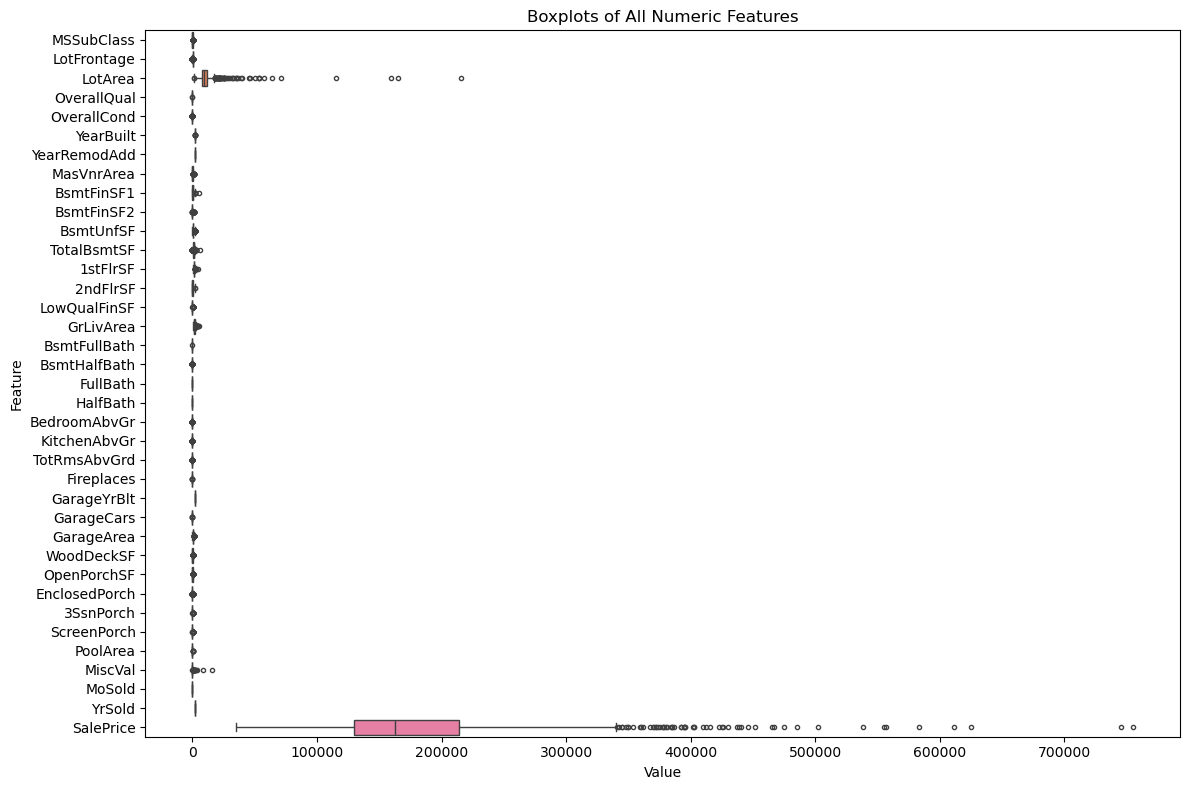

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train.select_dtypes(include=['int64','float64']), orient='h', fliersize=3)
plt.title("Boxplots of All Numeric Features")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Categorical Consistency

* Cast `MSSubClass` to categorical (was int).
* All other string codes align with data dictionary; no manual renaming needed.

In [11]:
train["MSSubClass"] = train["MSSubClass"].astype("object")

# Exploratory Data Analysis (EDA)

> **Goal:** Uncover patterns, spot anomalies, test assumptions—without yet
> building models.

## Summary stats for numeric features

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


## Inspect categorical features

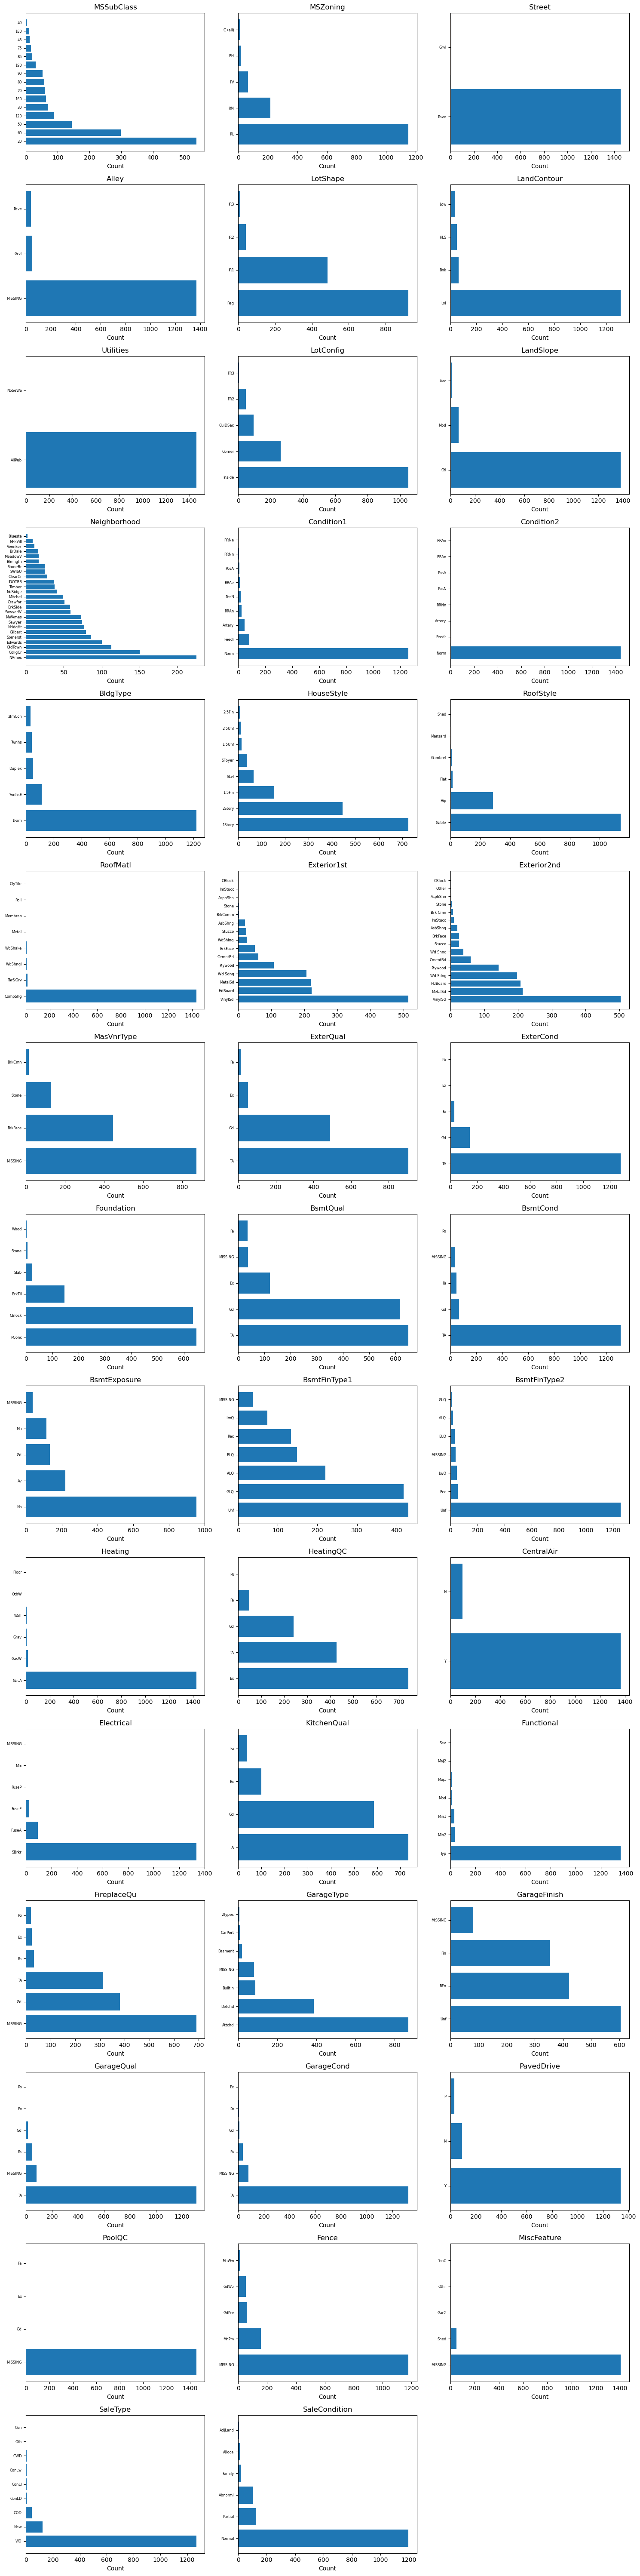

In [13]:
# Identify categorical columns
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Decide on grid layout
n = len(cat_cols)
cols = 3
rows = math.ceil(n / cols)

# Build subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Loop and draw each bar chart
for ax, col in zip(axes, cat_cols):
    counts = train[col].fillna('MISSING').value_counts()
    ax.barh(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Count')
    ax.tick_params(axis='y', labelsize=6)

# Hide any unused axes
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## House price distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


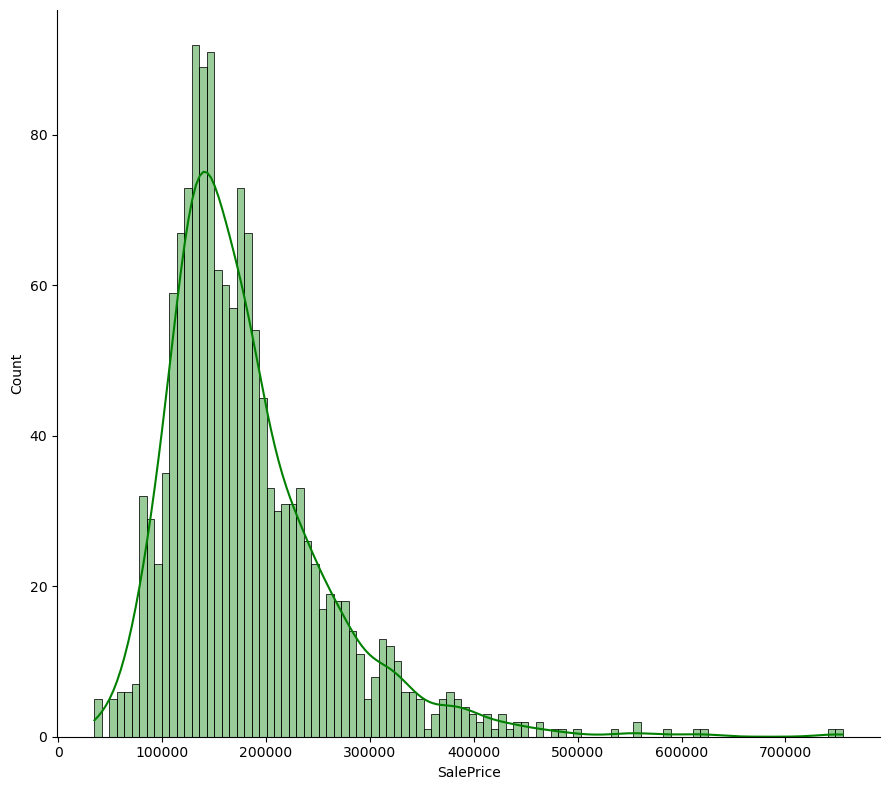

In [14]:
print(train["SalePrice"].describe())

sns.displot(
    data=train,
    x="SalePrice",
    kind="hist",         # you can also use kind="kde" or kind="ecdf"
    bins=100,
    color="g",
    alpha=0.4,
    kde=True,            # only works when kind="hist"
    height=8,
    aspect=9/8           # width = aspect × height
)

## Numeric data distribution

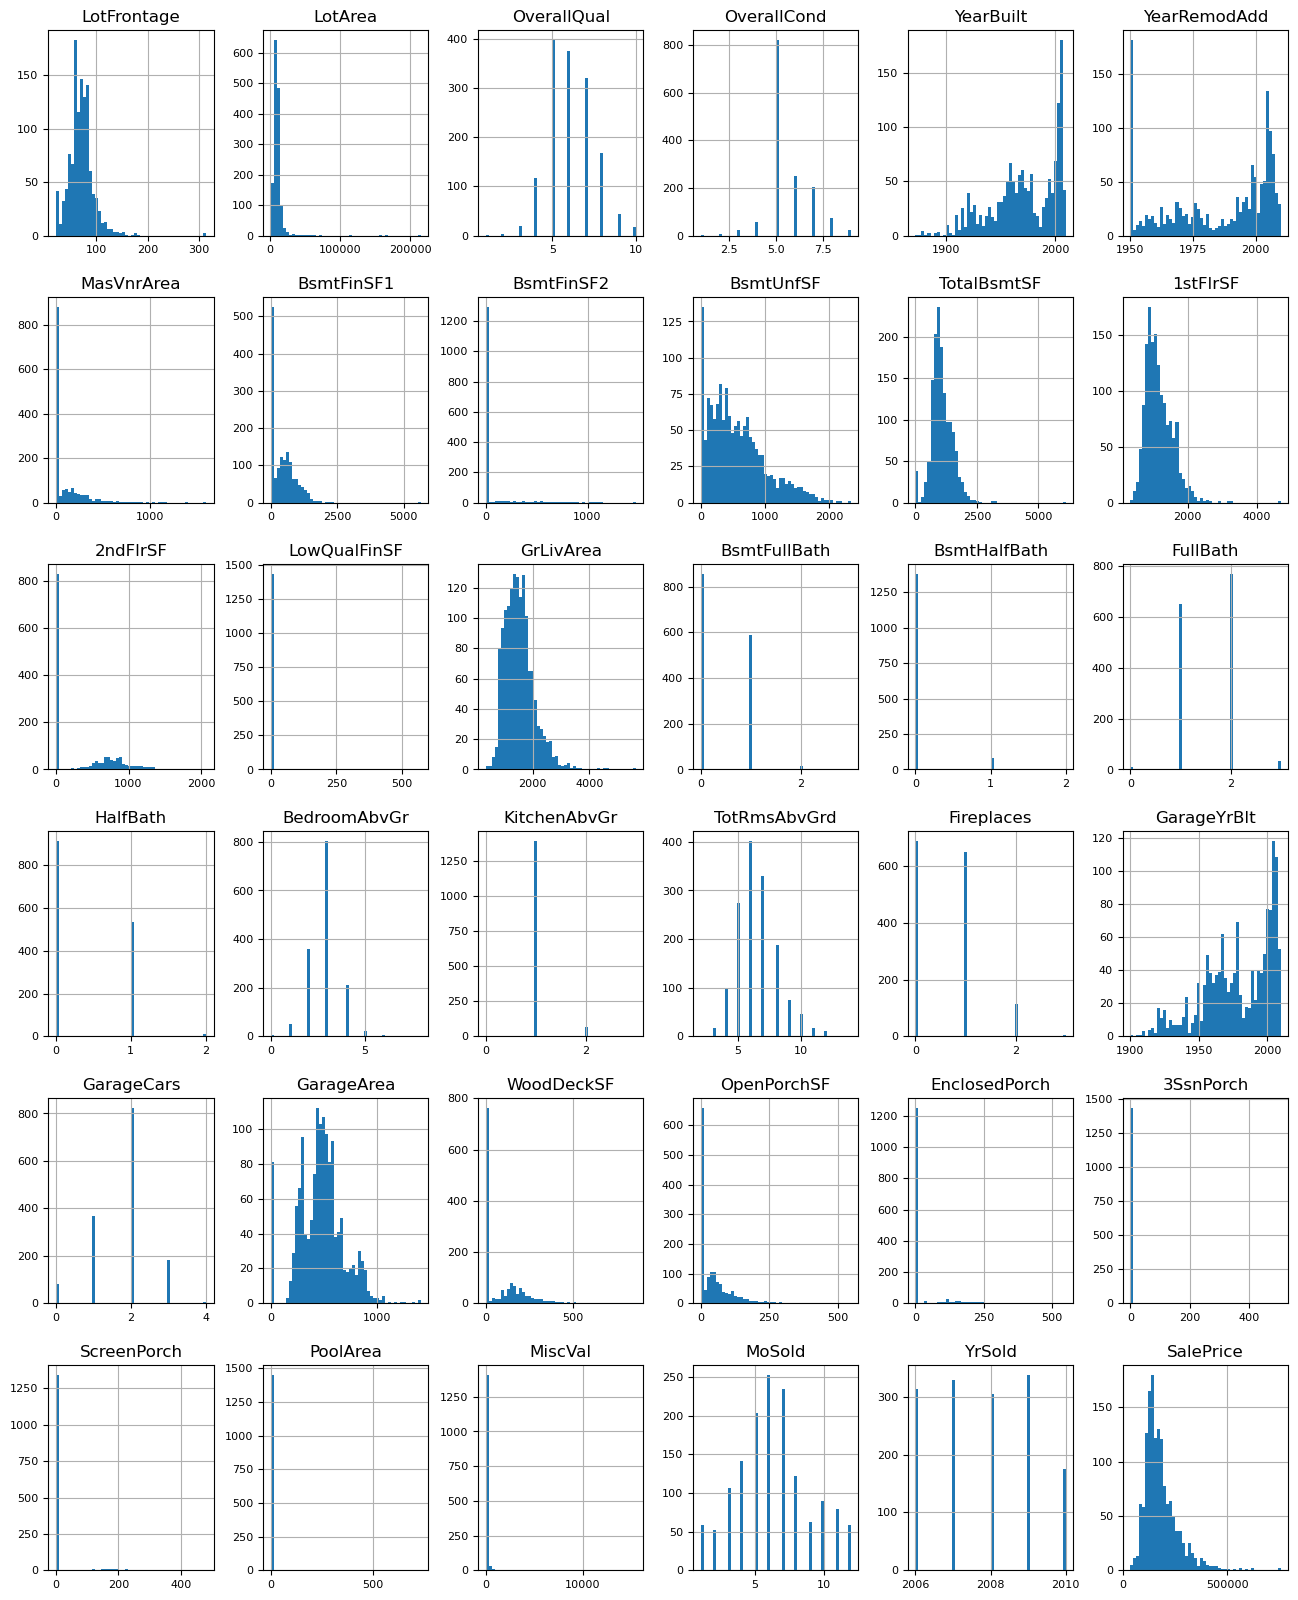

In [15]:
train \
    .select_dtypes(
        include=['float64', 'int64']
    ) \
    .hist(
        figsize=(16, 20),
        bins=50,
        xlabelsize=8,
        ylabelsize=8
    );

# Feature Engineering & Selection

> **Goal:** Transform raw inputs into signal-rich features, and pick the ones
> most predictive.

**New Features**

I did not use any new features. However, I could have tried the following:

* `HouseAge` = `YrSold` – `YearBuilt`
* `RemodelAge` = `YrSold` – `YearRemodAdd`
* `TotalSF` = `GrLivArea` + `TotalBsmtSF`

**Encoding**

Categorical fields have `"MISSING"` filled in for missing data and are one-hot
encoded.

**Scaling**

Numeric data uses the median for missing data and z-score scaling for features
fed to the multilayer perceptron (MLP). The label is set to a logarithmic scale.

**Feature Pruning**

I did not perform any feature pruning on the dataset. However, I could drop
extremely sparse features (e.g. `PoolQC`) or other low importance features that
don't improve cross‐val performance.

**Dimensionality Reduction**

I do not apply dimensionality reduction here. Instead I preserve
interpretability and let tree ensembles handle the high dimensionality.

## Pipeline

`../src/house_prices/featurize.py` defines the data preprocessing and feature
engineering pipeline. The pipeline:
* splits the raw DataFrame into train/validation sets
* handles missing values
* encodes categorical variables
* conditionally scales numeric features for the mlp using the z-score
  normalization
* scales the label to a logarithmic scale
* prepares inputs for both scikit-learn models and TensorFlow Decision Forests
  models (YDF)

### For linear, YDF tree, and XGBoost models

In [16]:
X_train, X_valid, y_train, y_valid,\
df_train_ydf, df_valid_ydf, preprocessor = make_preprocessor(train)

### For Keras MLP

In [17]:
X_train_mlp, X_valid_mlp, _, _, _, _, _ = make_preprocessor(train, scale_numeric=True)

# Model Training & Tuning

> **Goal:** Fit candidate algorithms and optimize them on your training data.

**Model Families**

* Linear (OLS, Ridge, Lasso, ElasticNet via scikit-learn)
* Trees (CART, RandomForest, GBT via YDF; XGBoost)
* Neural net (Keras MLP)

**Hyperparameters & Search**

* Linear: regularization strength α via built-in cross-validation.
* CART/RF: depth, min-examples, number of trees, feature-subsample; grid or
  random search with Optuna.
* GBT/XGB: learning rate, trees, subsample, regularization via Bayesian (Optuna
  TPE).
* MLP: layers, units, dropout, weight decay, optimizers, learning rate schedules
  with Hyperband pruning.

**Validation Split**

I used a 80/20 hold-out validation set with fixed seed.

**Compute Considerations**

I used parallel threads for trees, early stopping for XGBoost and pruning for
MLP. Computation and inference were acceptable, though the comprehensive
hyperparameter search took a while with 4 vCPUs and 2 Nvidia T4 GPUs.

## Linear Models

### Unregularized linear regression / ordinary least squares

In [18]:
lr = LinearRegression(fit_intercept=True, n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

### Ridge (Grid via RidgeCV)

In [19]:
ridge_alphas = np.logspace(-3, 3, 13)
ridge = RidgeCV(alphas=ridge_alphas, store_cv_values=True)
ridge.fit(X_train, y_train)
print("Ridge     α* =", ridge.alpha_)

Ridge     α* = 10.0


### Lasso (built-in LassoCV)

In [20]:
lasso_alphas = np.logspace(-4, 0, 50)
lasso = LassoCV(alphas=lasso_alphas, cv=5, n_jobs=-1, max_iter=5000)
lasso.fit(X_train, y_train)
print("Lasso     α* =", lasso.alpha_)

Lasso     α* = 0.0007906043210907702


### ElasticNet (ElasticNetCV)

In [21]:
en_alpha    = np.logspace(-4, 0, 30)
en_l1_ratio = np.linspace(0.1, 0.9, 9)
enet = ElasticNetCV(
    alphas=en_alpha,
    l1_ratio=en_l1_ratio,
    cv=5,
    n_jobs=-1,
    max_iter=5000
)
enet.fit(X_train, y_train)
print("ElasticNet α*, l1_ratio* =", enet.alpha_, enet.l1_ratio_)

ElasticNet α*, l1_ratio* = 0.0032903445623126675 0.1


## Tree-based models

### Classification and regression trees (CART) - Single Decision Tree

In [22]:
# Define the full grid
cart_search_space = {
    "max_depth":    [3, 5, 10, 15, None],
    "min_examples": [1, 5, 10, 20],
}
cart_sampler = GridSampler(cart_search_space)
study_cart = optuna.create_study(
    direction="minimize",
    sampler=cart_sampler
)
cart_obj = make_cart_objective(df_train_ydf, df_valid_ydf, y_valid)
# n_trials = len(max_depth) x len (min_examples) = 5 × 4 = 20
study_cart.optimize(cart_obj, n_trials=20, show_progress_bar=True)

print("CART best params:", study_cart.best_params)

Best trial: 0. Best value: 0.195397: 100%|██████████| 20/20 [00:01<00:00, 15.19it/s]

CART best params: {'max_depth': None, 'min_examples': 10}


### Ensemble methods

#### Bagging

##### Random forest

In [23]:
rf_sampler = RandomSampler(seed=42)
study_rf = optuna.create_study(
    direction="minimize",
    sampler=rf_sampler
)
rf_obj   = make_rf_objective(  df_train_ydf, df_valid_ydf, y_valid)
study_rf.optimize(rf_obj, n_trials=50, show_progress_bar=True)

print("RF    best params:", study_rf.best_params)

Best trial: 44. Best value: 0.144604: 100%|██████████| 50/50 [04:14<00:00,  5.10s/it]

RF    best params: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}


#### Boosting

##### Gradient Boosted Trees

In [24]:
study_gbts = optuna.create_study(direction="minimize")
gbts_obj = make_gbts_objective(df_train_ydf, df_valid_ydf, y_valid)
study_gbts.optimize(gbts_obj, n_trials=50, show_progress_bar=True)

print("GBT best params:", study_gbts.best_params)

Best trial: 48. Best value: 0.13272: 100%|██████████| 50/50 [21:56<00:00, 26.34s/it]  

GBT best params: {'num_trees': 633, 'shrinkage': 0.020595180245354398, 'max_depth': 5, 'subsample': 0.6013074929997522, 'num_candidate_attributes_ratio': 0.8008706786541414, 'l2_regularization': 4.670385610777738}


##### Extreme gradient boosting (XGBoost)

In [25]:
study_xgb = optuna.create_study(direction="minimize")
xgb_obj  = make_xgb_objective(  X_train, X_valid, y_train, y_valid)
study_xgb.optimize(xgb_obj, n_trials=50, show_progress_bar=True)

print("XGB best params:", study_xgb.best_params)

Best trial: 41. Best value: 0.151247: 100%|██████████| 50/50 [08:28<00:00, 10.18s/it]

XGB best params: {'n_estimators': 558, 'lr': 0.24691048262738285, 'max_depth': 5, 'subsample': 0.905959423990969, 'colsample_bytree': 0.8292861928629667, 'gamma': 0.00924884724974195, 'reg_alpha': 4.065713235208165, 'reg_lambda': 6.5927523970131885}


## Neural network

Here I will implement a multi-layer perceptron (MLP). I am using Optuna with Hyperband pruning.

In [26]:
pruner = HyperbandPruner()
study_mlp = optuna.create_study(direction="minimize", pruner=pruner)
mlp_obj  = make_mlp_objective(  X_train_mlp, X_valid_mlp, y_train, y_valid)
study_mlp.optimize(mlp_obj, n_trials=50, show_progress_bar=True)

print("Best hyperparameters:", study_mlp.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]I0000 00:00:1748194078.391819  431604 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748194082.184186  442229 service.cc:152] XLA service 0x7f6320003910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748194082.184345  442229 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-05-25 12:28:02.271344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748194082.333149  442229 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748194083.951599  442229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the l

Best hyperparameters: {'n_layers': 1, 'units_l0': 1024, 'activation': 'prelu', 'dropout': 0.29225960748104124, 'weight_decay': 0.0014946007806646378, 'batch_norm': False, 'lr': 0.0008090988022012259, 'optimizer': 'adam', 'batch_size': 128, 'lr_schedule': 'step_decay', 'patience': 5, 'max_epochs': 200}


# Model Evaluation & Validation

> **Goal:** Rigorously assess performance on unseen data and guard against
> overfitting.

## Metric

RMSE on log1p price as it is single label regression and it is the
competition metric.

## Results on Hold-out

In [27]:
print("Root Mean Square Error (RMSE) on Validation Dataset:")
print("Linear.....", root_mean_squared_error(y_valid, lr.predict(X_valid)))
print("Ridge......", root_mean_squared_error(y_valid, ridge.predict(X_valid)))
print("Lasso......", root_mean_squared_error(y_valid, lasso.predict(X_valid)))
print("ElasticNet.", root_mean_squared_error(y_valid, enet.predict(X_valid)))
print("CART.......", study_cart.best_value)
print("RF.........", study_rf.best_value)
print("GBT........", study_gbts.best_value)
print("XGB........", study_xgb.best_value)
print("MLP........", study_mlp.best_value)

Root Mean Square Error (RMSE) on Validation Dataset:
Linear..... 0.13766379322021058
Ridge...... 0.13737899997613365
Lasso...... 0.13450333387170046
ElasticNet. 0.13612149279947822
CART....... 0.1953968912388397
RF......... 0.1446035681844609
GBT........ 0.13271959996572372
XGB........ 0.15124695314399064
MLP........ 0.4196225825139284


Gradient Boosted Trees (GBT) is the winning model with lowest RMSE on the
validation set.

In [28]:
# Grab the best params
best_params = study_gbts.best_params
print("Best hyperparameters:", best_params)

# Reconstruct & train the final model
final_learner = ydf.GradientBoostedTreesLearner(
    label="SalePrice",
    task=ydf.Task.REGRESSION,
    **best_params
)
final_model = final_learner.train(df_train_ydf)

# Predict on validation (or any) DataFrame
preds_valid = final_model.predict(df_valid_ydf)

# Confirm RMSE on validation set. It should match value before.
rmse = np.sqrt(root_mean_squared_error(y_valid, preds_valid))
print("Final RMSE on validation set:", rmse)

Best hyperparameters: {'num_trees': 633, 'shrinkage': 0.020595180245354398, 'max_depth': 5, 'subsample': 0.6013074929997522, 'num_candidate_attributes_ratio': 0.8008706786541414, 'l2_regularization': 4.670385610777738}
Final RMSE on validation set: 0.36430701333590015


# Interpretation & Communication

> **Goal:** Translate technical findings into actionable insights for
> stakeholders.

## Feature Importance

Top drivers: `OverallQual`, `GrLivArea`, `TotalBsmtSF` and `GarageArea`.

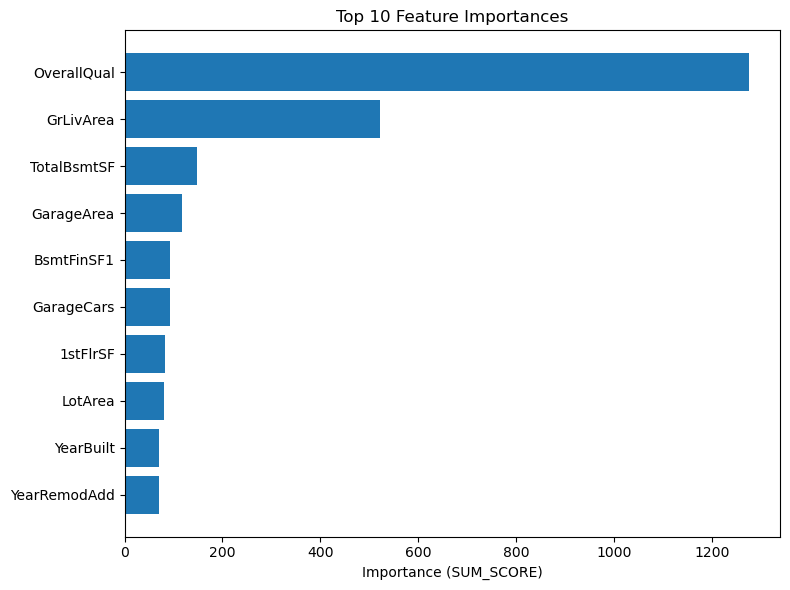

In [29]:
# Global importances
# 1) Grab the raw (importance, feature) tuples
importances = final_model.variable_importances()["SUM_SCORE"]

# 2) Turn into a DataFrame for convenience
df_vi = pd.DataFrame(importances, columns=["importance", "feature"])
# If feature is a ColumnSpec, extract its name
df_vi["feature"] = df_vi["feature"].apply(lambda f: getattr(f, "name", f))

# 3) Sort and take top 10
df_top10 = df_vi.sort_values("importance", ascending=False).head(10)

# 4) Plot as a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(df_top10["feature"][::-1], df_top10["importance"][::-1])
plt.xlabel("Importance (SUM_SCORE)")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

## Shapley Value Insights

Looking at the Shapley values, we see the big players are the overall quality of
the property, the living area, the size of the garage, the size of the basement,
and the lot area.

100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


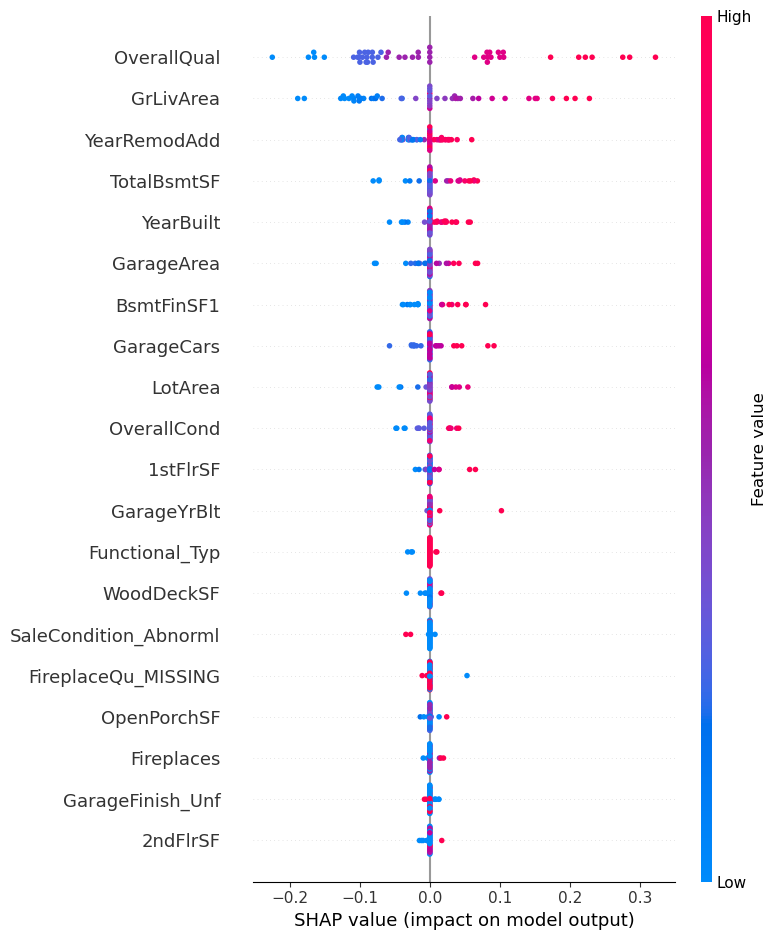

In [30]:
# SHAP summary plot
# 1) Prepare feature matrix (no label column)
X = df_valid_ydf.drop("SalePrice", axis=1)

# 2) Select a small “background” sample to estimate expectations
#    (too large and KernelExplainer will be *very* slow)
background = X.sample(100, random_state=42)

# 3) Wrap your model.predict function
predict_fn = lambda data: final_model.predict(
    pd.DataFrame(data, columns=X.columns)
)

# 4) Create the explainer
explainer = shap.KernelExplainer(predict_fn, background)

# 5) Compute approximate Shapley values for a subset
shap_vals = explainer.shap_values(X.iloc[:50], nsamples=200)

# 6) Plot the summary (beeswarm) for those 50 samples
shap.summary_plot(shap_vals, X.iloc[:50], feature_names=X.columns)

100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


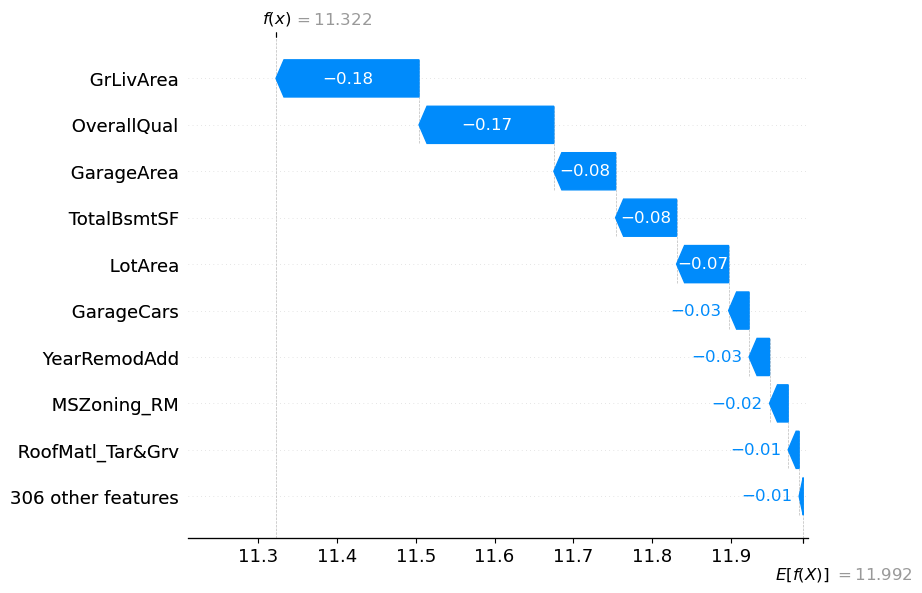

In [31]:
# Choose a single instance index to explain
idx = 5   # the 6th house in validation set
x_instance = X.iloc[idx:idx+1]   # keep as DataFrame

# Compute SHAP values for just that one instance
shap_vals = explainer.shap_values(x_instance, nsamples=200)

# Waterfall plot (static, great for reports)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_vals[0],
    x_instance.iloc[0],
    max_display=10
)

## Trade-offs & Recommendations

Reducing the feature count will improve interpretability, reduce the complexity
of data acquisition / transformation and speed up training / inference. This
comes at the cost of increased error, but it is minimal as only a few features
dominate.

I recommend keeping only `OverallQual`, `GrLivArea`, `TotalBsmtSF`, `GarageArea`
and `LotArea`.

# Deployment & Monitoring

> **Goal:** Put the model into production, ensure it runs reliably, and watch
> for drift.

## Serving Architecture

Since this is a Kaggle competition, there is no need for a serving architecture.
I just submit the results on the test set for evaluation and scoring.

However if we were to serve this model, we could export the trained GBT via
model.save() or to a TensorFlow SavedModel format for use with TensorFlow
Serving via `model.to_tensorflow_saved_model()`. This model could then be
accessed via API or used to run batch predictions using an Airflow job.

## Monitoring

In this case, the model can be monitored via both the standard drift of the
statistical distribution of feature values from a baseline statistical
distribution and via a rise in the RMSE. The reason is as houses are sold, model
predictions could be checked against these ground truth values.

Even if the ground truth values were not used for evaluating RMSE, the change in
the statistical distribution of feature values could be used to trigger a
retraining pipeline for the model using new feature data and ground truth
labels. The distribution of the new feature values are compared to the
distribution of the training feature values and of the distance measures between
the two distributions is above a threshold, then the retraining is triggered
using the new data.

For calculating the distributions, two different methods are used. For
categorical features, the distribution is the percentage of each possible value
of the feature. For numeric features, the range of possible values is divided
into equal intervals and the percentage of feature values in each interval is
used.

For the distance measures, there are also two methods. For categorical
distributions, the L-infinity distance is used where it focuses on categories
that jump dramatically and is insensitive to minor fluctuations across many
categories. For numeric distributions, the Jensen-Shannon divergence is used
where it handles zero counts well and focuses on the overall shape change.

## CI/CD & Versioning

For this competition, just keeping a git repo would suffice. But to be more
comprehensive, the below CI/CD pipeline outlines the major steps.

### Code Versioning

**Git Branching Strategy**

* **Main**: Always green, holds production-ready code.
* **Develop**: Integrates feature branches and holds code that’s ready for
  integration testing.
* **Feature/{name}**: Short-lived branches for new preprocessing steps, model
  changes, metric-tracking, etc.
* **Release/{version}** & **Hotfix/{version}**: For preparing production
  releases and urgent fixes.

**Pull Requests & Reviews**

   * Require at least one peer review on every PR.
   * Include automated linting, unit‐test, and type‐checking (e.g. `flake8`,
     `pytest`).

### Environment & Dependency Management

**Containerization (Docker)**

* **Base Image**: Pick a slim Python image or a ML image with CUDA for GPUs.
* **Lock Dependencies**: Freeze with `pip-compile` or `poetry lock` so CI always
  installs the exact same libraries.

**Environment Files**

   * Keep `requirements.txt` or `environment.yml` under version control.
   * Tag any breaking dependency upgrades in `CHANGELOG.md`.

### CI Pipeline

**Build Stage**

* **Lint**: Run `flake8`/`black --check`.
* **Unit Tests**: Test data‐processing functions, metric calculations, model‐I/O
  code.
* **Security Scans**: e.g. `bandit` for common Python security issues.

**Integration Stage**

* **Small-scale Training**: Kick off a fast training run on a tiny dataset to
  ensure end-to-end pipeline health.
* **Model Serialization Test**: Load and save the model (e.g. via `joblib` or
  TensorFlow SavedModel) and verify predictions match.

**Artifact Publishing**

* Upon passing all tests, build a Docker image and push to a registry (Docker
  Hub, ECR, GCR).

### CD Pipeline

**Staging Deployment**

* Deploy your Docker image to a staging environment (Kubernetes, ECS, Cloud
  Run).
* Run end-to-end smoke tests against a staging endpoint (e.g. send sample
  payloads, verify responses).

**Production Deployment**

* **Canary Release**: Gradually shift traffic from the old model version to the
  new version.
* **Automated Rollback**: If error rate or latency exceeds thresholds, revert to
  the last healthy image automatically.

### Model Artifact & Data Versioning

**Model Registry (e.g. MLflow)**

* Version models with metadata (metrics, parameters, git-SHA).

**Data Versioning (e.g. DVC)**

* Track preprocessed datasets and feature artifacts alongside the code.

**Automated Promotion**

* After training completes in CI, register the model under "Staging".
* Upon manual or automated validation, promote to "Production" stage.

## Submission

Here, I predict on the competition test data using the trained GBT model.

In [32]:
# Load the raw test set
df_test = pd.read_csv("test.csv")
test_ids = df_test["Id"]

# Preprocess exactly as done training
# Drop the Id column, keep features only
X_test = df_test.drop("Id", axis=1)

# Apply the ColumnTransformer fit earlier
# (this will do median‐impute, one‐hot, etc.)
X_test_prep = preprocessor.transform(X_test)

# Rebuild a DataFrame for YDF, with the same columns used for train
feat_names = preprocessor.get_feature_names_out()
# Remove the "num__" or "cat__" prefix so names match what YDF saw at train time
clean_names = [fn.split("__", 1)[1] for fn in feat_names]
df_test_ydf = pd.DataFrame(X_test_prep, columns=clean_names)

# Predict with your final_model
preds = np.expm1(final_model.predict(df_test_ydf))

# Build and save the submission file
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission), "rows.")

Wrote submission.csv with 1459 rows.


# Reflection & Continuous Improvement

> **Goal:** Capture lessons learned, evolve the solution, and plan for future
> cycles.

## What Went Well

* Reproducible pipeline with ColumnTransformer & single `make_preprocessor`
  function.
* Optuna + pruning cut manual tuning time.

## Bottlenecks

* Hyperparameter sweeps still consume ~30 minutes on Kaggle.

## Next Steps

* Ensemble multiple top models (e.g. stacking).
* Inject external data (e.g. school scores, walkability, latitude / longitude)
  for richer signal.
* Incorporate the new features identified in the Feature Engineering portion of
  the notebook.
* Prune the dataset by removing low value features.

## Documentation & Handoff

* This notebook + a README outlining how it fits in with the other competition
  notebooks in the GitHub repo.